<a href="https://colab.research.google.com/github/martinpius/Behind-Keras-Layers-and-Models/blob/main/Customized_layers_and_Models_from_scratch_Using_Subclassing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are using Google Colab with tensorflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"{type(e)}: {e}\n....Please Load Your Drive....")

def mytime_set(x):
  h = int(x / (60 * 60))
  m = int(x % (60 * 60) / 60)
  s = int(x % 60)
  return f"{h}: {m:>02}: {s:>05.2f}"

mytime_set(134.874622)

Mounted at /content/drive
You are using Google Colab with tensorflow version: 2.4.0


'0: 02: 14.00'

In [28]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [5]:
#Layer subclassing is a usefull procedure
#which enable construction or customization of any kera's layer to meet the user's demand


In [6]:
#An example of a dense layer from the scratch using layer-subclassing. We can do this in multiple ways as follows

In [11]:
#Method 1.Define the inputs shape at the begining

In [19]:
class MyLayer(keras.layers.Layer):
  def __init__(self, units = 64, inputs_shape = (32,)):
    super(MyLayer, self).__init__()
    w_init = tf.random_normal_initializer()
    b_init = tf.zeros_initializer()
    self.w = tf.Variable(initial_value = w_init(shape = (units, inputs_shape)), dtype = 'float32', trainable = True, name = 'weights')
    self.b = tf.Variable(initial_value = b_init(shape = (units,)), dtype = 'float32', trainable = True, name = 'bias')
  
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

In [26]:
layer = MyLayer(32,32)
x = tf.ones(shape = (5,32))
out = layer(x)

In [24]:
assert layer.weights == [layer.w,layer.b]

In [28]:
#We can define the same layer in a shortcut way by adding weights directly using add_method

In [35]:
class NewLayer(keras.layers.Layer):
  def __init__(self, units = 32, inputs_shape = 32):
    super(NewLayer, self).__init__()
    self.w = self.add_weight(shape = (units, inputs_shape), initializer = 'random_normal', trainable = True)
    self.b = self.add_weight(shape = (units,), initializer = 'zeros', trainable = True)
  
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

In [39]:
x = tf.ones(shape = (10,32))
layer1 = NewLayer(32,32)
out1 = layer1(x)

In [40]:
out1.shape

TensorShape([10, 32])

In [43]:
#The third method is to define the input shape later 

In [45]:
class Layer1(keras.layers.Layer):
  def __init__(self, units = 32):
    super(Layer1, self).__init__()
    self.units = units
  
  def build(self, inputs_dim):
    self.w = self.add_weight(shape = (inputs_dim[-1], self.units), initializer = 'random_normal',trainable = True)
    self.b = self.add_weight(shape = (self.units,), initializer = 'zeros', trainable = True)
  
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

layer2 = Layer1(32)
out = layer2(x)
display(out.shape)

TensorShape([10, 32])

In [46]:
#We can have both trainable and no-trainable weights in a layer. Some weights may be
#added just to enable specified computations and we might not want to train them.
#We simply change the trainable argument to non-trainable

In [47]:
class Weight_Adjust(keras.layers.Layer):
  def __init__(self, units = 32, inputs_dim = 32, mask = 32):
    super(Weight_Adjust, self).__init__()
    self.mask = self.add_weight(shape = (mask, units), initializer = 'random_normal', trainable = False)
    self.w = self.add_weight(shape = (inputs_dim, units), initializer = 'random_normal', trainable = True)
    self.b = self.add_weight(shape = (units, ), initializer = 'zeros',trainable = True)
  
  def call(self, inputs):
    out = tf.matmul(tf.matmul(inputs, self.mask), self.w) + self.b
    return out
  

In [48]:
wt_adjust = Weight_Adjust(32,32)
x1 = tf.ones((10,32))
x2 = tf.ones((10,32))
out2 = wt_adjust([x1,x2])

In [49]:
out2.shape

TensorShape([2, 10, 32])

In [50]:
out2

<tf.Tensor: shape=(2, 10, 32), dtype=float32, numpy=
array([[[ 0.02049323,  0.02542326,  0.03373767, -0.0011565 ,
          0.06054437,  0.01168849, -0.09340455, -0.025712  ,
          0.01951009,  0.02734433, -0.07522879,  0.00860099,
         -0.0756005 ,  0.02798784,  0.07091984,  0.05057644,
          0.1689526 , -0.03399925, -0.08270165,  0.16689663,
          0.07483273, -0.02432632,  0.12009586,  0.01072896,
         -0.02103187,  0.08050467, -0.03570008, -0.00499672,
          0.09577608, -0.15050277,  0.05651817, -0.08321209],
        [ 0.02049323,  0.02542326,  0.03373767, -0.0011565 ,
          0.06054437,  0.01168849, -0.09340455, -0.025712  ,
          0.01951009,  0.02734433, -0.07522879,  0.00860099,
         -0.0756005 ,  0.02798784,  0.07091984,  0.05057644,
          0.1689526 , -0.03399925, -0.08270165,  0.16689663,
          0.07483273, -0.02432632,  0.12009586,  0.01072896,
         -0.02103187,  0.08050467, -0.03570008, -0.00499672,
          0.09577608, -0.150502

In [51]:
#Calling a layer inside anothe layer: This is usefull when we want to use
#features from a separate layer defined outside the main class

In [52]:
class Reusable(keras.layers.Layer):
  def __init__(self, units = 32, **kwargs):
    super(Reusable,self).__init__(**kwargs)
    self.units = units
  
  def build(self, inputs_dim):
    self.w = self.add_weight(shape = (inputs_dim[-1], self.units), initializer = 'random_normal', trainable = True)
    self.b = self.add_weight(shape = (self.units,), initializer = 'random_normal', trainable = True)
  
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b
  

In [53]:
class BigLayer(keras.layers.Layer):
  def __init__(self, units = 32, **kwargs):
    super(BigLayer, self).__init__(**kwargs)
    self.dense1 = Reusable(units = 64, name = 'first_layer')
    self.dense2 = Reusable(units = 32, name = 'second_layer')
    self.dense3 = Reusable(units = 10, name = 'outputs')
  
  def call(self, inputs):
    x = self.dense1(inputs)
    x = tf.nn.relu(x)
    x = self.dense2(x)
    x = tf.nn.relu(x)
    x = self.dense3(x)
    out = tf.nn.softmax(x)
    return out


In [54]:
biglayer = BigLayer(32)
y = biglayer(x)


In [55]:
y.shape

TensorShape([10, 10])

In [57]:
#Check the number of parameters to know how many layers are stacked together
print(f"weights: {len(biglayer.weights)}: trainable weights: {len(biglayer.trainable_weights)}")

weights: 6: trainable weights: 6


In [58]:
#Adding the loss and metrics using add_loss and add_metrics
#These quantities may be incorporated into the customized training loop 

In [59]:
#Consider a simple loss in term of regularization

In [60]:
class LayerLoss(keras.layers.Layer):
  def __init__(self, adj_rate = 0.25, units = 64, **kwargs):
    super(LayerLoss, self).__init__(**kwargs)
    self.adj_rate = adj_rate
    self.units = units
  
  def call(self, inputs):
    out = tf.reduce_mean(inputs * self.adj_rate)
    self.add_loss(out)
    return inputs
    

In [66]:
class UseLoss(keras.layers.Layer):
  def __init__(self, **kwargs):
    super(UseLoss, self).__init__(**kwargs)
    self.myloss = LayerLoss()
  
  def call(self, inputs):
    out_loss = self.myloss(inputs)
    return out_loss
  

In [67]:
loss_out = UseLoss()
#The inner layer isnot used yet
assert len(loss_out.losses) == 0

In [68]:
#We can assign the input to the outer layer and use our loss for the first time

In [69]:
loss_out(tf.ones(shape = (3,3)))

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)>

In [71]:
#Now we have one component as we have used the loss fn
assert len(loss_out.losses) == 1

In [4]:
class Regularize(keras.layers.Layer):
  def __init__(self, my_rate = 0.0025):
    super(Regularize, self).__init__()
    self.my_rate = my_rate
  
  def call(self, inputs):
    out = tf.reduce_sum(inputs * self.my_rate)
    self.add_loss(out)
    return inputs

class MyReg_Layer(keras.layers.Layer):
  def __init__(self, units = 32, **kwargs):
    super(MyReg_Layer, self).__init__(**kwargs)
    self.units = units
    self.regulate = Regularize()
  
  def call(self, inputs):
    return self.regulate(inputs)


my_regularized = MyReg_Layer()
assert len(my_regularized.losses) == 0


In [15]:
out = my_regularized(tf.ones(3,2))

In [16]:
assert len(my_regularized.losses) == 1

In [17]:
out

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 1., 1.], dtype=float32)>

In [18]:
#We can also add l1 or l2 norm and into a custom layer
#Lets build a dense layer with l1-regularization


In [19]:
class L1_Norm(keras.layers.Layer):
  def __init__(self, units = 64, **kwargs):
    super(L1_Norm, self).__init__(**kwargs)
    self.units = units
    self.dense_1 = tf.keras.layers.Dense(units = units,
                                         activation = 'relu',
                                         kernel_initializer = 'random_normal',
                                         kernel_regularizer = tf.keras.regularizers.l1(1e-3))
  
  def call(self, inputs):
    return self.dense_1(inputs)
    

In [20]:
l1_norm = L1_Norm()
out = l1_norm(tf.ones(shape = (2,2)))

In [21]:
out

<tf.Tensor: shape=(2, 64), dtype=float32, numpy=
array([[0.0864865 , 0.        , 0.        , 0.04331492, 0.09201752,
        0.        , 0.        , 0.11194619, 0.06611573, 0.03948602,
        0.0649175 , 0.        , 0.04465878, 0.09146149, 0.        ,
        0.        , 0.03862193, 0.        , 0.        , 0.        ,
        0.        , 0.01794118, 0.        , 0.00712905, 0.        ,
        0.03994192, 0.        , 0.0616428 , 0.        , 0.00870519,
        0.03962398, 0.04717988, 0.07840874, 0.        , 0.07658093,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00424338, 0.03877949, 0.08029762, 0.        , 0.17415181,
        0.06788321, 0.09625886, 0.0585838 , 0.10838908, 0.12037892,
        0.        , 0.02387283, 0.01737687, 0.04533543, 0.        ,
        0.        , 0.04486705, 0.01031284, 0.00100743, 0.00591414,
        0.05857783, 0.        , 0.04151004, 0.1365701 ],
       [0.0864865 , 0.        , 0.        , 0.04331492, 0.09201752,
        0.

In [22]:
display(l1_norm.losses) #this print out the l1 norm wrt the dense_1 layer

[<tf.Tensor: shape=(), dtype=float32, numpy=0.0052457266>]

In [23]:
#We can train the model using the above defined regularizers as losses or combined  them with the main loss

In [31]:
#Consider a simple mlp
inputs = keras.Input(shape = (10,))
x = keras.layers.Dense(units = 64, activation = 'relu', kernel_initializer = 'random_normal')(inputs)
x = MyReg_Layer()(x)
outputs = keras.layers.Dense(units = 10, activation = 'softmax')(x)

In [32]:
model = keras.Model(inputs = inputs, outputs = outputs, name = 'mlp')

Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
my_reg__layer_2 (MyReg_Layer (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________


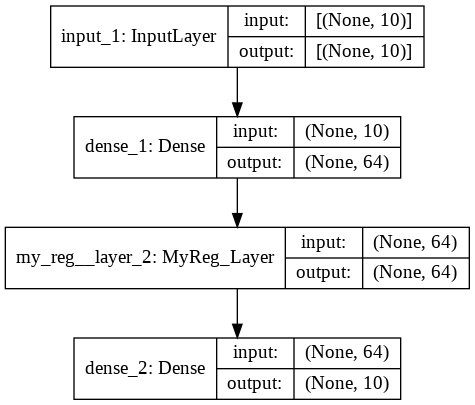

In [26]:
model.summary()
keras.utils.plot_model(model = model, to_file = 'mlp.png', show_shapes = True)

In [27]:
#We can compile the above model with/without a loss function
model.compile(optimizer = 'Adam', metrics = 'mse')


In [30]:
model.fit(np.random.random(size = (3,10)), np.random.random(size = (3,10)), epochs = 3, verbose = 2)

Epoch 1/3
1/1 - 0s - loss: 0.0202 - mse: 0.2563
Epoch 2/3
1/1 - 0s - loss: 0.0187 - mse: 0.2563
Epoch 3/3
1/1 - 0s - loss: 0.0173 - mse: 0.2563


In [33]:
#We can add a main loss to the model as follows and there will be some improvement in the mse#
model.compile(loss = 'MeanSquaredError', optimizer = 'RMSprop', metrics = ['mse'])

In [34]:
model.fit(np.random.random(size = (3,10)), np.random.random(size = (3,10)), epochs = 3, verbose = 2)

Epoch 1/3
1/1 - 1s - loss: 0.2352 - mse: 0.2228
Epoch 2/3
1/1 - 0s - loss: 0.2314 - mse: 0.2223
Epoch 3/3
1/1 - 0s - loss: 0.2291 - mse: 0.2220


In [36]:
#The add_metric method can be included in a keras layer to track the performance of the model. 
#As an example, consider the following classification problem.
#its inputs true labels and predictions. 
#Its then compute the (accuracy) and the loss and tracking them using (add_loss,add_metric) methods 

In [37]:
class MyClassifier(keras.layers.Layer):
  def __init__(self,**kwargs):
    super(MyClassifier, self).__init__(**kwargs)
    self.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits= True)
    self.metric_fn = tf.keras.metrics.CategoricalAccuracy()
  
  def call(self, labels, preds, sample_weights = None):
    loss1 = self.loss_fn(labels, preds, sample_weights)
    self.add_loss(loss1)
    acc1 = self.metric_fn(labels,preds,sample_weights)
    self.add_metric(acc1)
    return tf.nn.softmax(preds)

In [38]:
classifier = MyClassifier()
labels = tf.ones(shape = (3,10))
preds = tf.ones(shape = (3,10))
out = classifier(labels, preds)

In [47]:
out.shape
classifier.metrics[0].result

<bound method Metric.__new__.<locals>.result_fn of <tensorflow.python.keras.metrics.CategoricalAccuracy object at 0x7f7ad6886d68>>

In [48]:
print(f"{out}\ncurrent metric: {(classifier.metrics[0].result)}")

[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]
current metric: <bound method Metric.__new__.<locals>.result_fn of <tensorflow.python.keras.metrics.CategoricalAccuracy object at 0x7f7ad6886d68>>


In [49]:
#We can also track this metric using fit method during training

In [66]:
inputs = keras.Input(shape = (10,))
labels = keras.Input(shape = (10,))
y_preds = keras.layers.Dense(units = 10)(inputs)
outputs = MyClassifier()(labels, y_preds)
model = keras.Model(inputs = [inputs, labels], outputs = outputs)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 10)           110         input_12[0][0]                   
__________________________________________________________________________________________________
my_classifier_5 (MyClassifier)  (None, 10)           2           input_13[0][0]                   
                                                                 dense_9[0][0]              

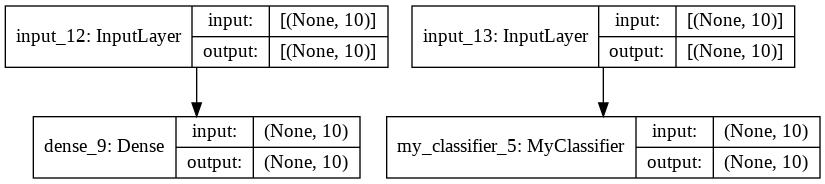

In [67]:
model.summary()
keras.utils.plot_model(model =  model, to_file = 'mym.png', show_shapes= True)

In [68]:
dfm = {'input_12': np.random.random(size = (10,10)),
       'input_13':np.random.random(size = (10,10))}

In [69]:
model.compile(optimizer = 'adam', metrics= ['accuracy'])

In [81]:
class BinLogistic(keras.layers.Layer):
  def __init__(self, name = None):
    super(BinLogistic, self).__init__(name = name)
    self.metric_fn = tf.keras.metrics.BinaryAccuracy()
    self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits = True)
  
  def call(self, y_real, y_pred, sample_weights = None):
    loss1 = self.loss_fn(y_real, y_pred, sample_weights)
    self.add_loss(loss1)
    acc1 = self.metric_fn(y_real, y_pred, sample_weights)
    self.add_metric(acc1, name = 'accuracy')
    return tf.nn.softmax(y_pred)
  


In [82]:
#Tracking using fit method

In [83]:
inputs = keras.Input(shape = (3,), name = 'inputs')
y_real = keras.Input(shape = (10,), name = 'labels')
y_pred = keras.layers.Dense(units = 10, name = 'predictions')(inputs)
outs = BinLogistic()(y_pred, y_real)
model = keras.Model(inputs = [inputs, y_real], outputs = outs)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 3)]          0                                            
__________________________________________________________________________________________________
predictions (Dense)             (None, 10)           40          inputs[0][0]                     
__________________________________________________________________________________________________
labels (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
bin_logistic_6 (BinLogistic)    (None, 10)           2           predictions[0][0]                
                                                                 labels[0][0]               

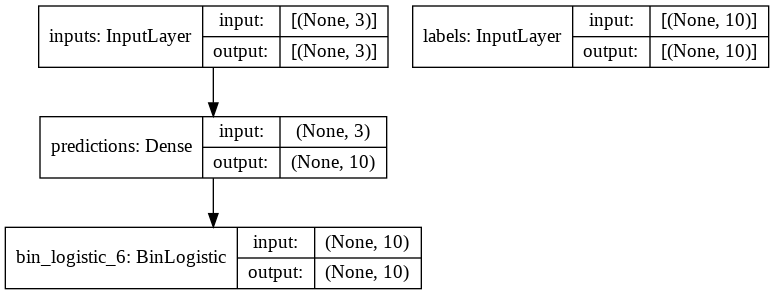

In [84]:
keras.utils.plot_model(model = model, to_file = 'mymn.png', show_shapes = True)

In [86]:
mydfm = {'inputs': np.random.random(size = (3,3)),
         'labels': np.random.random(size = (3,10))}

In [87]:
model.compile(optimizer = 'Adam')

In [89]:
model.fit(mydfm, epochs = 3, verbose = 2)

Epoch 1/3
1/1 - 0s - loss: 0.9721 - binary_accuracy: 0.0000e+00
Epoch 2/3
1/1 - 0s - loss: 0.9710 - binary_accuracy: 0.0000e+00
Epoch 3/3
1/1 - 0s - loss: 0.9699 - binary_accuracy: 0.0000e+00
